### Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install wandb
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
wandb: Currently logged in as: sidharth-singh (galvanizer). Use `wandb login --relogin` to force relogin


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import torch.optim as optim

import os

from PIL import Image, ImageOps

import random

#import any other library you need below this line
import wandb
from glob import glob
from torch.utils.data.dataset import Subset
from sklearn.model_selection import train_test_split as tts

### Loading data

Upload the data in zip format to Colab. Then run the cell below.

### Defining the Dataset Class

In [4]:

class CellData(Dataset):
    def __init__(self, data_dir:str, size:int, train:bool = True, train_test_split:float = 0.8, augment_data:bool = True):
        ##########################inputs##################################
        #data_dir(string) - directory of the data#########################
        #size(int) - size of the images you want to use###################
        #train(boolean) - train data or test data#########################
        #train_test_split(float) - the portion of the data for training###
        #augment_data(boolean) - use data augmentation or not#############
        super(CellData, self).__init__()
        #initialize the data class
        self.data_dir = data_dir
        self.size = size
        self.augment_data = augment_data
        self.train_test_split = train_test_split
        self.images = sorted(glob(os.path.join(data_dir,'scans','*.bmp')))
        self.labels = sorted(glob(os.path.join(data_dir, 'labels', '*.bmp')))
        print("Image array: ", self.images)
        print("Labels array: ", self.labels)
        self.train = train
        self.train_idx, self.test_idx = tts(list(range(len(self.images))), train_size=train_test_split)

        if self.train:
          self.train_split()
        else:
          self.test_split()

    def train_split(self):
      temp = list()
      temp_lbl = list()
      for idx in self.train_idx:
        temp.append(self.images[idx])
        temp_lbl.append(self.labels[idx])
      self.images = sorted(temp)
      self.labels = sorted(temp_lbl)

    def test_split(self):
      temp = list()
      temp_lbl = list()
      for idx in self.test_idx:
        temp.append(self.images[idx])
        temp_lbl.append(self.labels[idx])
      self.images = sorted(temp)
      self.labels = sorted(temp_lbl)

    def __getitem__(self, idx):
        #load image and mask from index idx of your data
        image = Image.open(self.images[idx]).resize((self.size,self.size))
        label = Image.open(self.labels[idx]).resize((self.size,self.size))
        
        #data augmentation part
        if self.augment_data:
            augment_mode = np.random.randint(0, 4)
            if augment_mode == 0:
              #flip image vertically
              image = ImageOps.flip(image)
              label = ImageOps.flip(label)

            elif augment_mode == 1:
              #flip image horizontally
              image = ImageOps.mirror(image)
              label = ImageOps.mirror(label)

            elif augment_mode == 2:
              #zoom image
              image = transforms.RandomResizedCrop(size=(self.size, self.size))(image)
              label = transforms.RandomResizedCrop(size=(self.size, self.size))(label)

            else:
              #rotate image
              image = image.rotate(90)
              label = label.rotate(90)

        image = transforms.PILToTensor()(image).type(torch.FloatTensor)
        label = transforms.PILToTensor()(label).type(torch.LongTensor)

        #normalizing values [0,1]
        image /=255.0
        return [image, label]
    
    def __len__(self):
        return len(self.images)


### Define the Model
1. Define the Convolution blocks
2. Define the down path
3. Define the up path
4. combine the down and up path to get the final model

In [5]:
class TwoConvBlock(nn.Module):
    """Double convolution layer for downward path and upward path."""
    
    def __init__(self, in_channels, out_channels, kernel_size=3, mid_channels=None, stride=1):
        super(TwoConvBlock, self).__init__()
        #initialize the block
        if not mid_channels:
            mid_channels = out_channels
        self.two_conv = nn.Sequential(
                nn.Conv2d(in_channels, mid_channels, kernel_size=kernel_size, bias=False, stride=stride),
                nn.BatchNorm2d(num_features=mid_channels, affine=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(mid_channels, out_channels, kernel_size=kernel_size, bias=False, stride=stride),
                nn.BatchNorm2d(num_features=out_channels, affine=True),
                nn.ReLU(inplace=True)
            )

    def forward(self, x):
        #implement the forward path
        return self.two_conv(x)

class DownStep(nn.Module):
    """The downward path of the U-Net."""
    
    def __init__(self, in_channel, out_channel):
        super(DownStep, self).__init__()
        #initialize the down path
        self.conv= nn.Sequential(
            TwoConvBlock(in_channel, out_channel)          
        )

    def forward(self, x):
        #implement the forward path
        return self.conv(x)
    

class UpStep(nn.Module):
    """The upward path for the U-Net."""
    
    def __init__(self, in_channels, out_channels, kernel_size = 2, stride = 2):
        super(UpStep, self).__init__()
        #initialize the up path
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size = kernel_size, stride = stride)
        self.conv = TwoConvBlock(in_channels, out_channels)

    def forward(self, x1, concat_tensor):
        #implement the forward path
        x1 = self.up(x1)

        # input is (B,C,H,W)
        diffY = concat_tensor.size()[2] - x1.size()[2]
        diffX = concat_tensor.size()[3] - x1.size()[3]

        deltaY = diffY//2
        deltaX = diffX//2

        #original paper crops the tensor from previous layer 
        cropped_tensor = concat_tensor[ : , : , deltaX:(concat_tensor.size()[2]-deltaX), deltaX:(concat_tensor.size()[3]-deltaX)]

        x = torch.cat([cropped_tensor, x1], dim=1)
        return self.conv(x)
    
class OutConvBlock(nn.Module):
    """Final output convolution layer."""
    
    def __init__(self, in_channels, out_channels, kernel_size=1):
        super(OutConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    """Main implementation of U-Net."""
    
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        #initialize the complete model
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride =2)
        #encoder
        self.inc = DownStep(self.n_channels, 64)
        self.down1 = DownStep(64, 128)
        self.down2 = DownStep(128, 256)
        self.down3 = DownStep(256, 512)
        self.down4 = DownStep(512, 1024)
        #upward
        self.up1 = UpStep(1024, 512)
        self.up2 = UpStep(512, 256)
        self.up3 = UpStep(256, 128)
        self.up4 = UpStep(128, 64)
        #output
        self.outc = OutConvBlock(64, self.n_classes)

    def forward(self, image):
      #image (bs,c,h,w)
      #downward path
      x1 = self.inc(image)
      x1_pool = self.max_pool_2x2(x1)
      x2 = self.down1(x1_pool)
      x2_pool = self.max_pool_2x2(x2)
      x3 = self.down2(x2_pool)
      x3_pool = self.max_pool_2x2(x3)
      x4 = self.down3(x3_pool)
      x4_pool = self.max_pool_2x2(x4)
      x5 = self.down4(x4_pool)
      #decoder
      x = self.up1(x5, x4)
      x = self.up2(x, x3)
      x = self.up3(x, x2)
      x = self.up4(x, x1)
      out = self.outc(x)
      return out


### Training

In [6]:
#Paramteres

#learning rate
lr = 1e-4
#number of training epochs
epoch_n = 20

#input image-mask size
image_size = 572
#root directory of project
root_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'Colab Notebooks', 'A2', 'A2')

#training batch size
batch_size = 4

#use checkpoint model for training
load = False

#use GPU for training
gpu = torch.cuda.is_available()

data_dir = os.path.join(root_dir, 'data/cells')


trainset = CellData(data_dir = data_dir, size = image_size)
trainloader = DataLoader(trainset, batch_size = 4, shuffle=True)

testset = CellData(data_dir = data_dir, size = image_size, train = False)
testloader = DataLoader(testset, batch_size = 4)

device = torch.device('cuda:0' if gpu else 'cpu')

#initializing weights and biases
wandb.init(project="Assignment 2", entity="sidharth-singh")

model = UNet(1,2).to(device)

if load:
    print('loading model')
    model.load_state_dict(torch.load('checkpoint.pt'))

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.00075)

wandb.config.update({
    "device": device,
    "learning_rate": lr,
    "epoch": epoch_n,
    "batch_size": batch_size,
    "image_size": image_size
})
model.train()

wandb.watch(model)
for e in range(epoch_n):
  epoch_loss = 0
  for i, data in enumerate(trainloader):
    image, label = data

    image = image.to(device)
    label = label.long().to(device)

    #zero the gradients before starting predictions
    optimizer.zero_grad()

    #forward + backward + optimize
    pred = model(image)

    #crop labels to match the prediction size
    crop_y = (label.shape[2] - pred.shape[2]) // 2
    crop_x = (label.shape[3] - pred.shape[3]) // 2

    label = label[:,:,crop_y: (label.shape[2] - crop_y), crop_x: (label.shape[3] - crop_x)]
    label = label.squeeze(1)
    
    loss = criterion(pred, label)

    loss.backward()

    optimizer.step()

    #stats
    epoch_loss += loss.item()

    print('batch %d --- Loss: %.4f' % (i, loss.item() / batch_size))
  wandb.log({
      "Loss": epoch_loss/len(trainset)
  })
  print('Epoch %d / %d --- Loss: %.4f' % (e + 1, epoch_n, epoch_loss / trainset.__len__()))

  torch.save(model.state_dict(), 'checkpoint.pt')

  # model.eval()

  # total = 0
  # correct = 0
  # total_loss = 0

  # with torch.no_grad():
  #   for i, data in enumerate(testloader):
  #     image, label = data

  #     image = image.unsqueeze(1).to(device)
  #     label = label.long().to(device)

  #     pred = model(image)
  #     crop_x = (label.shape[1] - pred.shape[2]) // 2
  #     crop_y = (label.shape[2] - pred.shape[3]) // 2

  #     label = label[:, crop_x: label.shape[1] - crop_x, crop_y: label.shape[2] - crop_y]

  #     loss = criterion(pred, label)
  #     total_loss += loss.item()

  #     _, pred_labels = torch.max(pred, dim = 1)

  #     total += label.shape[0] * label.shape[1] * label.shape[2]
  #     correct += (pred_labels == label).sum().item()

  #   print('Accuracy: %.4f ---- Loss: %.4f' % (correct / total, total_loss / testset.__len__()))


Image array:  ['/content/drive/MyDrive/Colab Notebooks/A2/A2/data/cells/scans/BMMC_10.bmp', '/content/drive/MyDrive/Colab Notebooks/A2/A2/data/cells/scans/BMMC_11.bmp', '/content/drive/MyDrive/Colab Notebooks/A2/A2/data/cells/scans/BMMC_12.bmp', '/content/drive/MyDrive/Colab Notebooks/A2/A2/data/cells/scans/BMMC_13.bmp', '/content/drive/MyDrive/Colab Notebooks/A2/A2/data/cells/scans/BMMC_14.bmp', '/content/drive/MyDrive/Colab Notebooks/A2/A2/data/cells/scans/BMMC_15.bmp', '/content/drive/MyDrive/Colab Notebooks/A2/A2/data/cells/scans/BMMC_16.bmp', '/content/drive/MyDrive/Colab Notebooks/A2/A2/data/cells/scans/BMMC_17.bmp', '/content/drive/MyDrive/Colab Notebooks/A2/A2/data/cells/scans/BMMC_18.bmp', '/content/drive/MyDrive/Colab Notebooks/A2/A2/data/cells/scans/BMMC_20.bmp', '/content/drive/MyDrive/Colab Notebooks/A2/A2/data/cells/scans/BMMC_21.bmp', '/content/drive/MyDrive/Colab Notebooks/A2/A2/data/cells/scans/BMMC_22.bmp', '/content/drive/MyDrive/Colab Notebooks/A2/A2/data/cells/scan

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sidharth-singh. Use `wandb login --relogin` to force relogin


batch 0 --- Loss: 0.1902
batch 1 --- Loss: 0.1808
batch 2 --- Loss: 0.1882
batch 3 --- Loss: 0.1756
batch 4 --- Loss: 0.1497
batch 5 --- Loss: 0.1445
batch 6 --- Loss: 0.2182
batch 7 --- Loss: 0.1393
Epoch 1 / 20 --- Loss: 0.1849
batch 0 --- Loss: 0.1784
batch 1 --- Loss: 0.1275
batch 2 --- Loss: 0.1526
batch 3 --- Loss: 0.1930
batch 4 --- Loss: 0.1295
batch 5 --- Loss: 0.1137
batch 6 --- Loss: 0.1171
batch 7 --- Loss: 0.1775
Epoch 2 / 20 --- Loss: 0.1586
batch 0 --- Loss: 0.1217
batch 1 --- Loss: 0.1419
batch 2 --- Loss: 0.1641
batch 3 --- Loss: 0.1461
batch 4 --- Loss: 0.1826
batch 5 --- Loss: 0.1145
batch 6 --- Loss: 0.1052
batch 7 --- Loss: 0.1158
Epoch 3 / 20 --- Loss: 0.1456
batch 0 --- Loss: 0.1189
batch 1 --- Loss: 0.1175
batch 2 --- Loss: 0.1155
batch 3 --- Loss: 0.1154
batch 4 --- Loss: 0.1132
batch 5 --- Loss: 0.1882
batch 6 --- Loss: 0.2603
batch 7 --- Loss: 0.1515
Epoch 4 / 20 --- Loss: 0.1574
batch 0 --- Loss: 0.1902
batch 1 --- Loss: 0.1262
batch 2 --- Loss: 0.1391
batch

In [7]:
model.eval()

total = 0
correct = 0
total_loss = 0

with torch.no_grad():
  for i, data in enumerate(testloader):
    image, label = data

    image = image.to(device)
    label = label.long().to(device)

    pred = model(image)

    #crop labels to match the prediction size
    crop_y = (label.shape[2] - pred.shape[2]) // 2
    crop_x = (label.shape[3] - pred.shape[3]) // 2

    label = label[:,:,crop_y: (label.shape[2] - crop_y), crop_x: (label.shape[3] - crop_x)]
    label = label.squeeze(1)

    loss = criterion(pred, label)
    total_loss += loss.item()

    _, pred_labels = torch.max(pred, dim = 1)

    total += label.shape[0] * label.shape[1] * label.shape[2]
    correct += (pred_labels == label).sum().item()
    wandb.log({
        "Training_Accuracy": correct/total
    })
  print('Accuracy: %.4f ---- Loss: %.4f' % (correct / total, total_loss / testset.__len__()))
  

Accuracy: 0.7633 ---- Loss: 0.1240


### Testing and Visualization

In [8]:
model.eval()

output_masks = []
output_labels = []
input_images = []

total = correct = 0
with torch.no_grad():
  for i in range(len(testset)):
    image, labels = testset.__getitem__(i)

    print("Image size: ", image.size())
    
    print("Labels size: ",  labels.size())
    input_image = image.unsqueeze(0).to(device)
    labels = labels.squeeze(0)
    pred = model(input_image)
    print("Labels size after squeeze: ",  labels.size())

    output_mask = torch.max(pred, dim = 1)[1].cpu().squeeze(0).numpy()


    print("Output mask shape: ", output_mask.shape)

    crop_x = (labels.shape[0] - output_mask.shape[0]) // 2
    crop_y = (labels.shape[1] - output_mask.shape[1]) // 2
    labels = labels[crop_x: labels.shape[0] - crop_x, crop_y: labels.shape[1] - crop_y].numpy()
    print("Labels shape : ", labels.shape)
    
    image = image.squeeze(0).squeeze(0)
    image = image[crop_x: image.shape[0] - crop_x, crop_y: image.shape[1] - crop_y].numpy()
    print(image.shape, end="\n\n")
    output_masks.append(output_mask)
    output_labels.append(labels)
    input_images.append(image)

    total += labels.shape[0] * labels.shape[1]
    correct += (output_mask[1] == labels).sum().item()
    wandb.log({
        "Testing_Accuracy": correct/total
    })


Image size:  torch.Size([1, 572, 572])
Labels size:  torch.Size([1, 572, 572])
Labels size after squeeze:  torch.Size([572, 572])
Output mask shape:  (388, 388)
Labels shape :  (388, 388)
(388, 388)

Image size:  torch.Size([1, 572, 572])
Labels size:  torch.Size([1, 572, 572])
Labels size after squeeze:  torch.Size([572, 572])
Output mask shape:  (388, 388)
Labels shape :  (388, 388)
(388, 388)

Image size:  torch.Size([1, 572, 572])
Labels size:  torch.Size([1, 572, 572])
Labels size after squeeze:  torch.Size([572, 572])
Output mask shape:  (388, 388)
Labels shape :  (388, 388)
(388, 388)

Image size:  torch.Size([1, 572, 572])
Labels size:  torch.Size([1, 572, 572])
Labels size after squeeze:  torch.Size([572, 572])
Output mask shape:  (388, 388)
Labels shape :  (388, 388)
(388, 388)

Image size:  torch.Size([1, 572, 572])
Labels size:  torch.Size([1, 572, 572])
Labels size after squeeze:  torch.Size([572, 572])
Output mask shape:  (388, 388)
Labels shape :  (388, 388)
(388, 388)



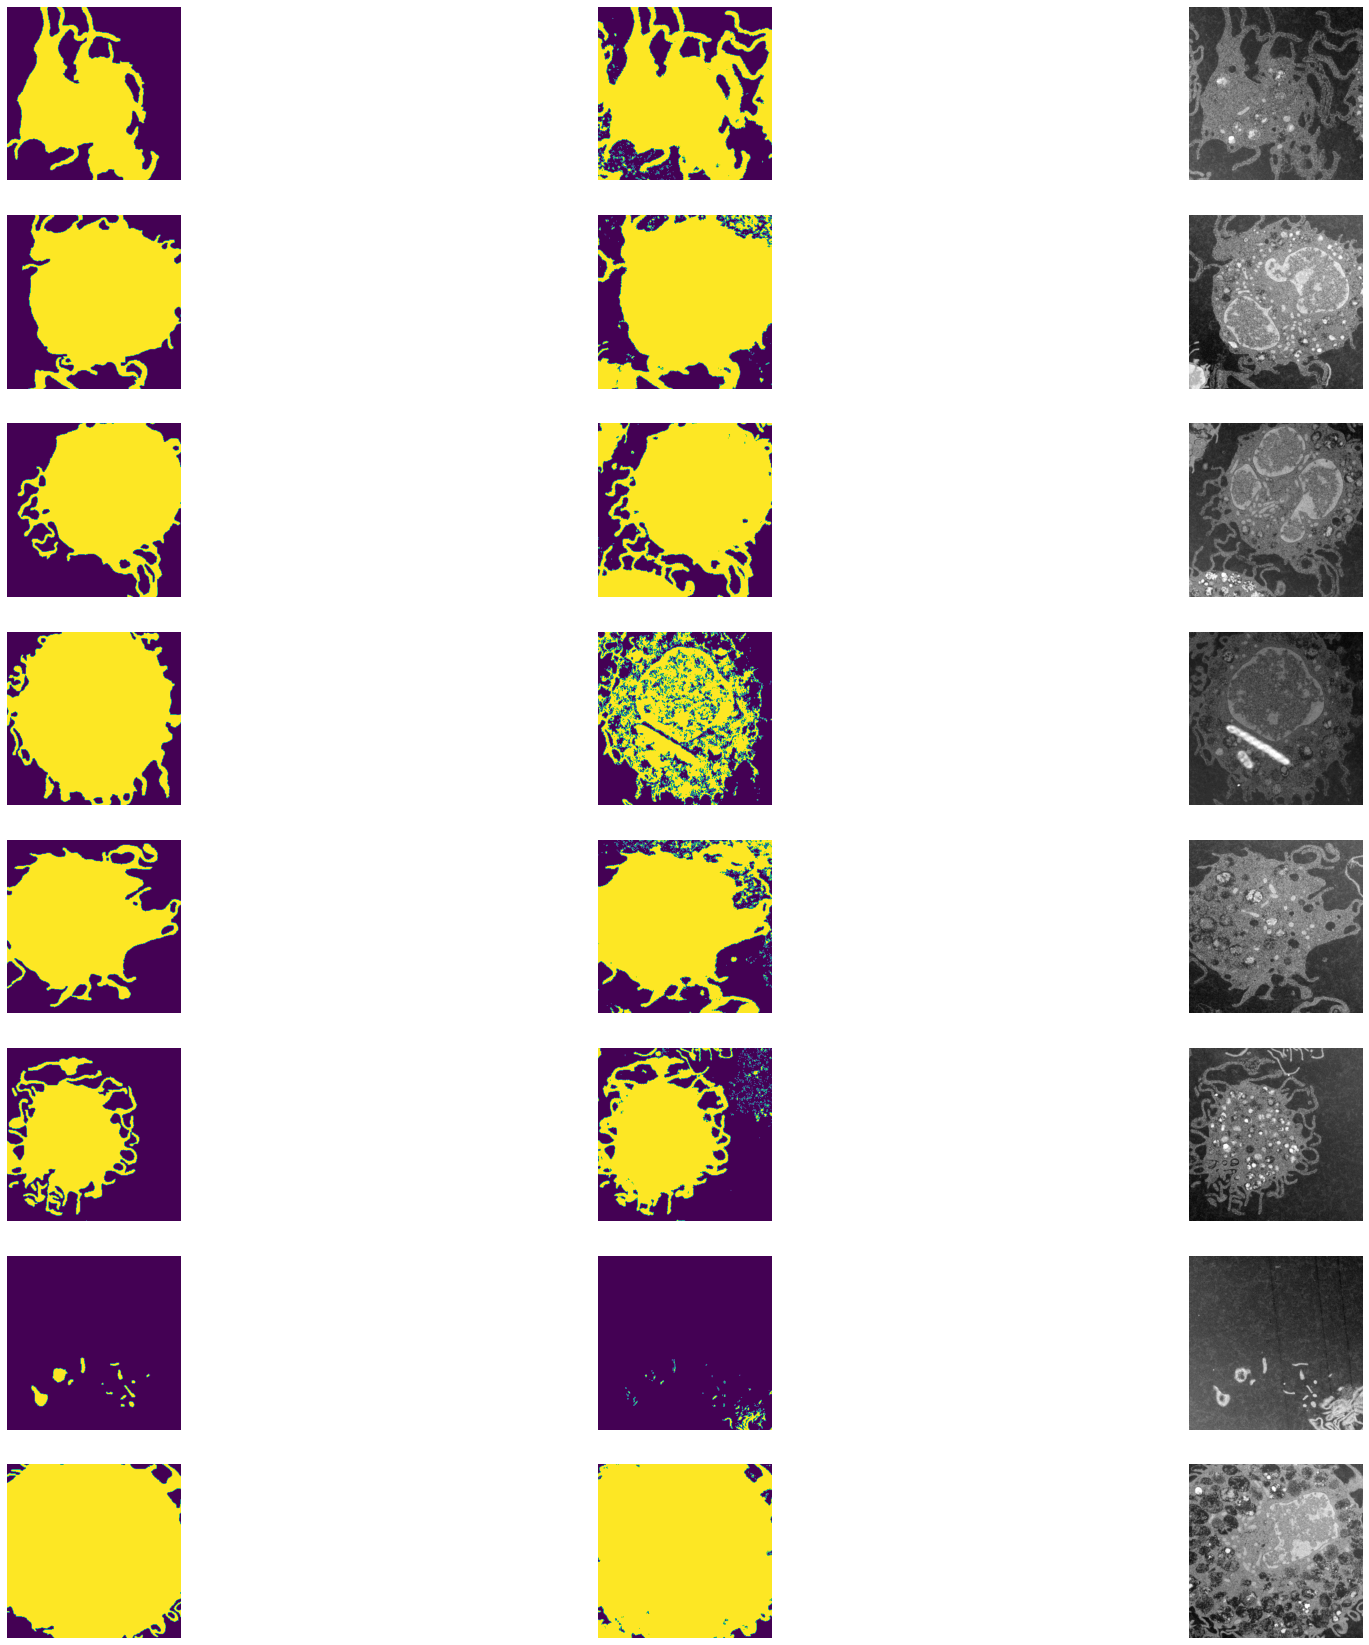

In [9]:
fig, axes = plt.subplots(testset.__len__(), 3, figsize = (30, 30))

for i in range(len(testset)):
  axes[i, 0].imshow(output_labels[i])
  axes[i, 0].axis('off')
  axes[i, 1].imshow(output_masks[i])
  axes[i, 1].axis('off')
  axes[i, 2].imshow(input_images[i], cmap='binary')
  axes[i, 2].axis('off')